# Detailed Regression Walkthrough — California Housing

A full end-to-end notebook: **data loading → EDA → missing value strategy → feature engineering → scaling/transformations → model building → hyperparameter tuning → evaluation & interpretation**.

This notebook is designed to match the level of detail in your uploaded notebook and to demonstrate techniques that typically improve regression performance beyond naive baselines.

In [2]:

# Quick imports for the notebook
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib, warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')
print('imports ready')


imports ready


## Load dataset and quick EDA

In [4]:

data = fetch_california_housing(as_frame=True)
if hasattr(data, 'frame') and 'MedHouseVal' in data.frame.columns:
    df = data.frame.copy()
else:
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['MedHouseVal'] = pd.Series(data.target, name='MedHouseVal')

print('shape:', df.shape)
display(df.head())
display(df.describe().T)
print('\nMissing values per column:')
print(df.isnull().sum())


shape: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,count,mean,std,min,25%,50%,75%,max
MedInc,20640.0,3.870671,1.899822,0.499900,2.563400,3.534800,4.743250,15.000100
HouseAge,20640.0,28.639486,12.585558,1.000000,18.000000,29.000000,37.000000,52.000000
AveRooms,20640.0,5.429000,2.474173,0.846154,4.440716,5.229129,6.052381,141.909091
AveBedrms,20640.0,1.096675,0.473911,0.333333,1.006079,1.048780,1.099526,34.066667
Population,20640.0,1425.476744,1132.462122,3.000000,787.000000,1166.000000,1725.000000,35682.000000
AveOccup,20640.0,3.070655,10.386050,0.692308,2.429741,2.818116,3.282261,1243.333333
Latitude,20640.0,35.631861,2.135952,32.540000,33.930000,34.260000,37.710000,41.950000
Longitude,20640.0,-119.569704,2.003532,-124.350000,-121.800000,-118.490000,-118.010000,-114.310000
MedHouseVal,20640.0,2.068558,1.153956,0.149990,1.196000,1.797000,2.647250,5.000010



Missing values per column:
MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64


## Feature engineering — create ratios and interactions

In [6]:

df_fe = df.copy()
df_fe['rooms_per_household'] = df_fe['AveRooms'] / (df_fe['HouseAge'] + 1)
df_fe['bedrooms_per_room'] = df_fe['AveBedrms'] / (df_fe['AveRooms'] + 1)
df_fe['population_per_household'] = df_fe['Population'] / (df_fe['AveOccup'] + 1)
display(df_fe.head())


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,rooms_per_household,bedrooms_per_room,population_per_household
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526,0.166289,0.128231,90.562500
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585,0.283552,0.134272,772.064990
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521,0.156380,0.115572,130.448737
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413,0.109761,0.157401,157.274131
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422,0.118526,0.148462,177.591019


## Target analysis and log-transform

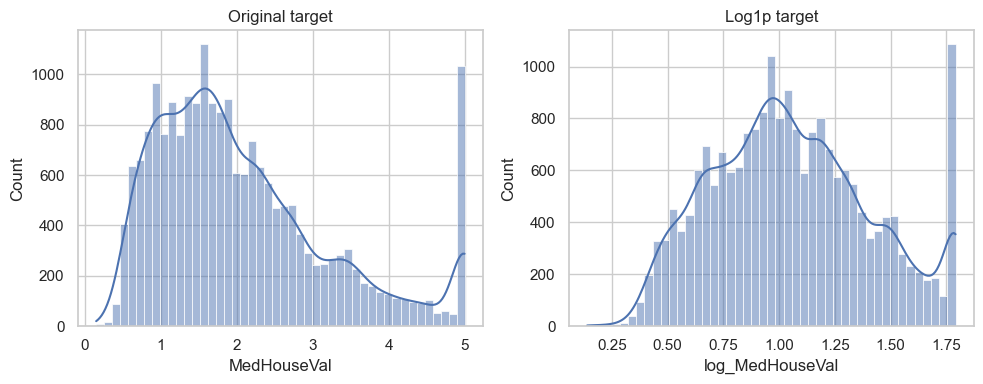

skew original: 0.9777632739098345 skew log: 0.2759390509171133


In [8]:

import numpy as np
import seaborn as sns, matplotlib.pyplot as plt
df_fe['log_MedHouseVal'] = np.log1p(df_fe['MedHouseVal'])
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df_fe['MedHouseVal'], kde=True).set_title('Original target')
plt.subplot(1,2,2)
sns.histplot(df_fe['log_MedHouseVal'], kde=True).set_title('Log1p target')
plt.tight_layout()
plt.show()
print('skew original:', df_fe['MedHouseVal'].skew(), 'skew log:', df_fe['log_MedHouseVal'].skew())


## Train-test split and baseline models

In [10]:

features = [c for c in df_fe.columns if c not in ['MedHouseVal','log_MedHouseVal']]
X = df_fe[features]
y = df_fe['MedHouseVal']
y_log = df_fe['log_MedHouseVal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Xtr, Xte, ytr_log, yte_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

numeric_features = X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features)
])

ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('poly', PolynomialFeatures(degree=2, include_bias=False)),
                                 ('model', Ridge(random_state=42))])

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1))])

gbr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', GradientBoostingRegressor(n_estimators=200, random_state=42))])

for name, pipe in [('Ridge', ridge_pipeline), ('RandomForest', rf_pipeline), ('GradientBoosting', gbr_pipeline)]:
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    r2 = r2_score(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    print(f'{name} -> R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')


TypeError: got an unexpected keyword argument 'squared'

## Train on log-target and inverse-transform predictions

In [ ]:

for name, pipe in [('Ridge', ridge_pipeline), ('RandomForest', rf_pipeline), ('GradientBoosting', gbr_pipeline)]:
    pipe.fit(Xtr, ytr_log)
    preds_log = pipe.predict(Xte)
    preds = np.expm1(preds_log)
    r2 = r2_score(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    mae = mean_absolute_error(y_test, preds)
    print(f'{name} (log-target) -> R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')


## Hyperparameter tuning example (RandomizedSearchCV)

In [ ]:

from scipy.stats import randint as sp_randint
rf = Pipeline(steps=[('preprocessor', preprocessor),
                     ('model', RandomForestRegressor(random_state=42, n_jobs=-1))])

param_dist = {
    'model__n_estimators': sp_randint(100, 500),
    'model__max_depth': sp_randint(3, 25),
    'model__min_samples_split': sp_randint(2, 20),
    'model__min_samples_leaf': sp_randint(1, 20),
    'model__max_features': ['auto', 'sqrt', 'log2', 0.5, 0.75]
}

rs = RandomizedSearchCV(rf, param_dist, n_iter=20, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, random_state=42)
rs.fit(X_train, y_train)
print('Best params:', rs.best_params_)
best_rf = rs.best_estimator_
preds = best_rf.predict(X_test)
print('Tuned RF -> R2:', r2_score(y_test, preds), 'RMSE:', mean_squared_error(y_test, preds, squared=False))


## Feature importance and save model

In [ ]:

try:
    importances = best_rf.named_steps['model'].feature_importances_
    feat_imp = pd.Series(importances, index=numeric_features).sort_values(ascending=False)
    display(feat_imp.head(15))
    feat_imp.head(15).plot(kind='bar', figsize=(8,4))
    plt.title('Top 15 RF importances')
    plt.show()
except Exception as e:
    print('No feature importances yet:', e)

joblib.dump(best_rf, '/mnt/data/best_rf_pipeline.joblib')
print('Saved to /mnt/data/best_rf_pipeline.joblib')
